In [4]:
from keras.layers import Conv3D,Conv2D, Flatten, Dense, Reshape, BatchNormalization
from keras.layers import Dropout, Input
from keras.layers import Add, Activation, AveragePooling2D, MaxPooling2D, ReLU
from keras.models import Model
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import classification_report
from operator import truediv
from plotly.offline import init_notebook_mode
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from utils import *
import plotly.express as px
import seaborn as sn

plt.style.use('Solarize_Light2')

init_notebook_mode(connected=True)
%matplotlib inline

In [2]:
## GLOBAL VARIABLES
dataset = 'PU'
test_ratio = 0.2
windowSize = 25
S = windowSize
K = 9
output_units = 9

#### Importation des donnés, utilisation de PCA, Création des cubes, split

In [6]:
X, y = loadData(dataset)
X,pca = applyPCA(X,numComponents=10)
X, y = createImageCubes(X, y, windowSize=windowSize)
Xtrain, Xtest, ytrain, ytest = splitTrainTestSet(X, y, 0.2)
Xtrain = Xtrain.reshape(-1, windowSize, windowSize, 10)
ytrain = to_categorical(ytrain)
Xtest = Xtest.reshape(-1, windowSize, windowSize, 10)
ytest = to_categorical(ytest)
Xtrain.shape, ytrain.shape


((34220, 25, 25, 10), (34220, 9))

#### Définition du modele : 

In [13]:
def second_model(shape = (S, S, 10), classes = output_units):
    X_input = Input(shape)
    X = Conv2D(32, (3, 3), strides = (1, 1), name = 'conv0')(X_input)
    X = BatchNormalization(axis = 3, name = 'bn0')(X)
    X = ReLU()(X)
    X = MaxPooling2D((2, 2), name='max_pool0')(X)
    X = Conv2D(64, (3, 3), strides = (1, 1), name = 'conv1')(X)
    X = BatchNormalization(axis = 3, name = 'bn1')(X)
    X = ReLU()(X)
    X = MaxPooling2D((2, 2), name='max_pool1')(X)
    X = Flatten()(X)
    X = Dense(512, activation='relu', name='fc0')(X)
    X = Dropout(0.5)(X)
    X = Dense(classes, activation='softmax', name='fc1')(X)
    model = Model(inputs = X_input, outputs = X, name='first_model')
    return model

In [14]:
second_model = second_model()
second_model.summary()

Model: "first_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 25, 25, 10)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv0 (Conv2D)                  │ (None, 23, 23, 32)     │         2,912 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn0 (BatchNormalization)        │ (None, 23, 23, 32)     │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_2 (ReLU)                  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool0 (MaxPooling2D)        │ (None, 11, 11, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 9, 9, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bn1 (BatchNormalization)        │ (None, 9, 9, 64)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ re_lu_3 (ReLU)                  │ (None, 9, 9, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pool1 (MaxPooling2D)        │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc0 (Dense)                     │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 551,209 (2.10 MB)

 Trainable params: 551,017 (2.10 MB)

 Non-trainable params: 192 (768.00 B)

#### Compilation et entrainement du modele

In [15]:
adam = Adam(learning_rate=0.001)
second_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

filepath = "second_model.keras"
checkpoint = ModelCheckpoint(filepath, monitor='accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

history = second_model.fit(x=Xtrain, y=ytrain, batch_size=256, epochs=100, callbacks=callbacks_list)

Epoch 1/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 139ms/step - accuracy: 0.8061 - loss: 0.7634
Epoch 1: accuracy improved from -inf to 0.92113, saving model to second_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 21s 140ms/step - accuracy: 0.8069 - loss: 0.7598
Epoch 2/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 143ms/step - accuracy: 0.9945 - loss: 0.0218
Epoch 2: accuracy improved from 0.92113 to 0.99562, saving model to second_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 19s 144ms/step - accuracy: 0.9945 - loss: 0.0217
Epoch 3/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 147ms/step - accuracy: 0.9986 - loss: 0.0068
Epoch 3: accuracy improved from 0.99562 to 0.99871, saving model to second_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 148ms/step - accuracy: 0.9986 - loss: 0.0068
Epoch 4/100
134/134 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step - accuracy: 0.9996 - loss: 0.0034
Epoch 4: accuracy improved from 0.99871 to 0.99947, saving model to second_model.keras
134/134 ━━━━━━━━━━━━━━━━━━━━ 20s 145ms/step - accuracy: 0.9996 - 

#### Récuperation des poids du meilleur callback

In [16]:
second_model.load_weights(filepath)
second_model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

#### Premiére evaluation

In [17]:
Y_pred_test = second_model.predict(Xtest)
y_pred_test = np.argmax(Y_pred_test, axis=1)

classification = classification_report(np.argmax(ytest, axis=1), y_pred_test)
print(classification)

268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1326
           1       1.00      1.00      1.00      3730
           2       1.00      1.00      1.00       420
           3       1.00      1.00      1.00       613
           4       1.00      1.00      1.00       269
           5       1.00      1.00      1.00      1006
           6       1.00      1.00      1.00       266
           7       1.00      1.00      1.00       737
           8       1.00      1.00      1.00       189

    accuracy                           1.00      8556
   macro avg       1.00      1.00      1.00      8556
weighted avg       1.00      1.00      1.00      8556



#### Etablissement du rapport d'évaluation du deuxieme modele : 

In [18]:
classification, conf, Test_loss, Test_accuracy, oa, each_acc, aa, kappa = reports(second_model, Xtest, ytest,dataset)
classification = str(classification)
confusion = str(conf)
file_name = "classification_report_second_model.txt"

with open(file_name, 'w') as x_file:
    x_file.write('DATASET ={}'.format(dataset))
    x_file.write('\n')    
    x_file.write('Test ratio ={}'.format(test_ratio))
    x_file.write('\n')
    x_file.write('Window size ={}'.format(windowSize))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Test loss (%)'.format(Test_loss))
    x_file.write('\n')
    x_file.write('{} Test accuracy (%)'.format(Test_accuracy))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{} Kappa accuracy (%)'.format(kappa))
    x_file.write('\n')
    x_file.write('{} Overall accuracy (%)'.format(oa))
    x_file.write('\n')
    x_file.write('{} Average accuracy (%)'.format(aa))
    x_file.write('\n')
    x_file.write('\n')
    x_file.write('{}'.format(classification))
    x_file.write('\n')
    x_file.write('{}'.format(confusion))

268/268 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
268/268 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 1.0000 - loss: 9.3304e-06


#### Confusion Matrix : 

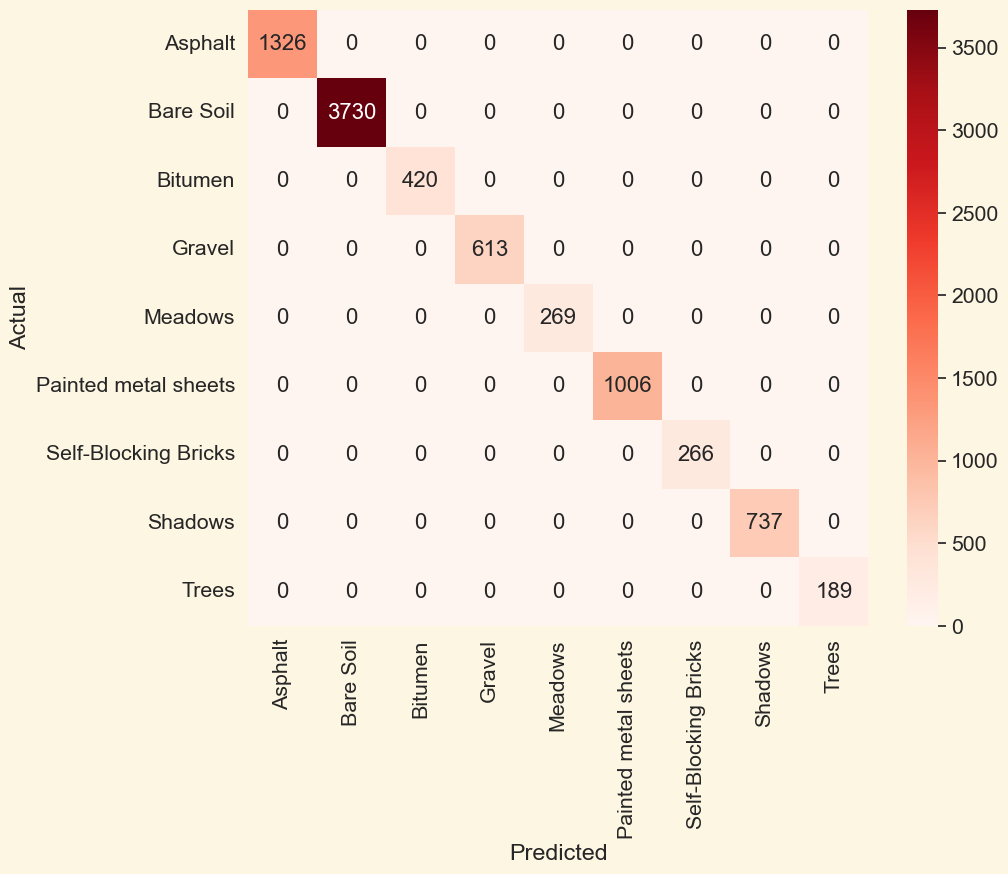

In [19]:

names = ['Asphalt','Meadows','Gravel','Trees', 'Painted metal sheets','Bare Soil','Bitumen',
                        'Self-Blocking Bricks','Shadows']


df_cm = pd.DataFrame(conf, columns=np.unique(names), index = np.unique(names))
df_cm.index.name = 'Actual'
df_cm.columns.name = 'Predicted'
plt.figure(figsize = (10,8))
sn.set(font_scale=1.4)#for label size
sn.heatmap(df_cm, cmap="Reds", annot=True,annot_kws={"size": 16}, fmt='d')
plt.savefig('cmap_second_model.png', dpi=1200)